# Ejercicio 2 - Ejercicios entragables grafos
##### Antonio Cabrera Landín 3ºMAIS
---

## Índice
1. **[Introducción](#1)**
2. **[Algoritmos para conseguir la probabilidad de que un grafo aleatorio sea conexo](#2)**
3. **[Algoritmos para obtener la probabilidad de conexión en función de la probabilidad de que el grafo sea conexo](#3)**
4. **[Análisis del resultado](#4)**

---
<a name="1"></a>
### 1. Introducción

#### 1.1 Enunciado

Para N vértices determinar p para que el grafo aleatorio $(p, N)$ sea conexo con la probabilidad PConexo dada, graficar la función $f(N)= p$ con $(p, N)$ **conexo** con la probabilidad del $50\%$.
Punto adicional por su aproximación analítica. 

#### 1.2 Instalar paquetes

In [1]:
!pip install matplotlib
!pip install scipy
!pip install numpy
!pip install networkx

#### 1.3. Importar paquetes

In [28]:
import matplotlib.pyplot as plt # Para crear gráficos
import time # Lo usaremos para medir el tiempo de ejecución
import scipy # Expansión de numpy
import numpy as np # Numpy
import networkx as nx # Lo usaremos para visualización de grafos
import itertools # Herramientas de combinatoria
from random import random # Números aleatorios

<a name="2"></a>
### 2. Algoritmos para conseguir la probabilidad de que un grafo aleatorio sea conexo

#### 2.1. Algoritmo sin optimización

##### 2.1.1. Explicación

Primero vamos a implementar el algoritmo que he encontrado en el foro de [StackExchange](https://math.stackexchange.com). [[1]](https://math.stackexchange.com/questions/584228/exact-probability-of-random-graph-being-connected)

$$f(n)=1 - \sum_{i=1}^{n-1} f(i) \binom{n-i}{i-1}(1-p)^{i(n-i)}$$

Se trata de un algoritmo recursivo en el que los casos bases son `pconexo=1` cuando el grafo tiene un único nodo (siempre es conexo) y `pconexo=p` cuando el grafo tiene 2 nodos.

##### 2.1.2. Implementación

In [26]:
# Source: https://math.stackexchange.com/questions/584228/exact-probability-of-random-graph-being-connected
def get_pconexo(N, p) -> float:

    # Casos base
    if N == 1:
        return 1
    elif N == 2:
        return p

    sum = 0

    for i in range(1, N):
        sum+=get_pconexo(i, p)*(scipy.special.comb(N-1, i-1))*(1 - p)**(i*(N-i))

    return 1-sum

print(f'Probabilidad de que un grafo aleatorio de 3 vértices con p=0.5 sea conexo: {get_pconexo(3, 0.5)}')

Probabilidad de que un grafo aleatorio de 3 vértices con p=0.5 sea conexo: 0.5


##### 2.1.2. Comprobar el resultado visualmente

Si dibujamos todos los grafos simples con 3 nodos, vemos que de los $2^{\binom{n}{2}} = 8$ grafos posibles, 4 de ellos son **conexos**.
Por lo tanto, si en nuestro **grafo aleatorio** tenemos una probabilidad de conexión entre aristas $p=0.5$, entonces la probabilidad de que un grafo aleatorio sea conexo es $\frac{4}{8} = 0.5$

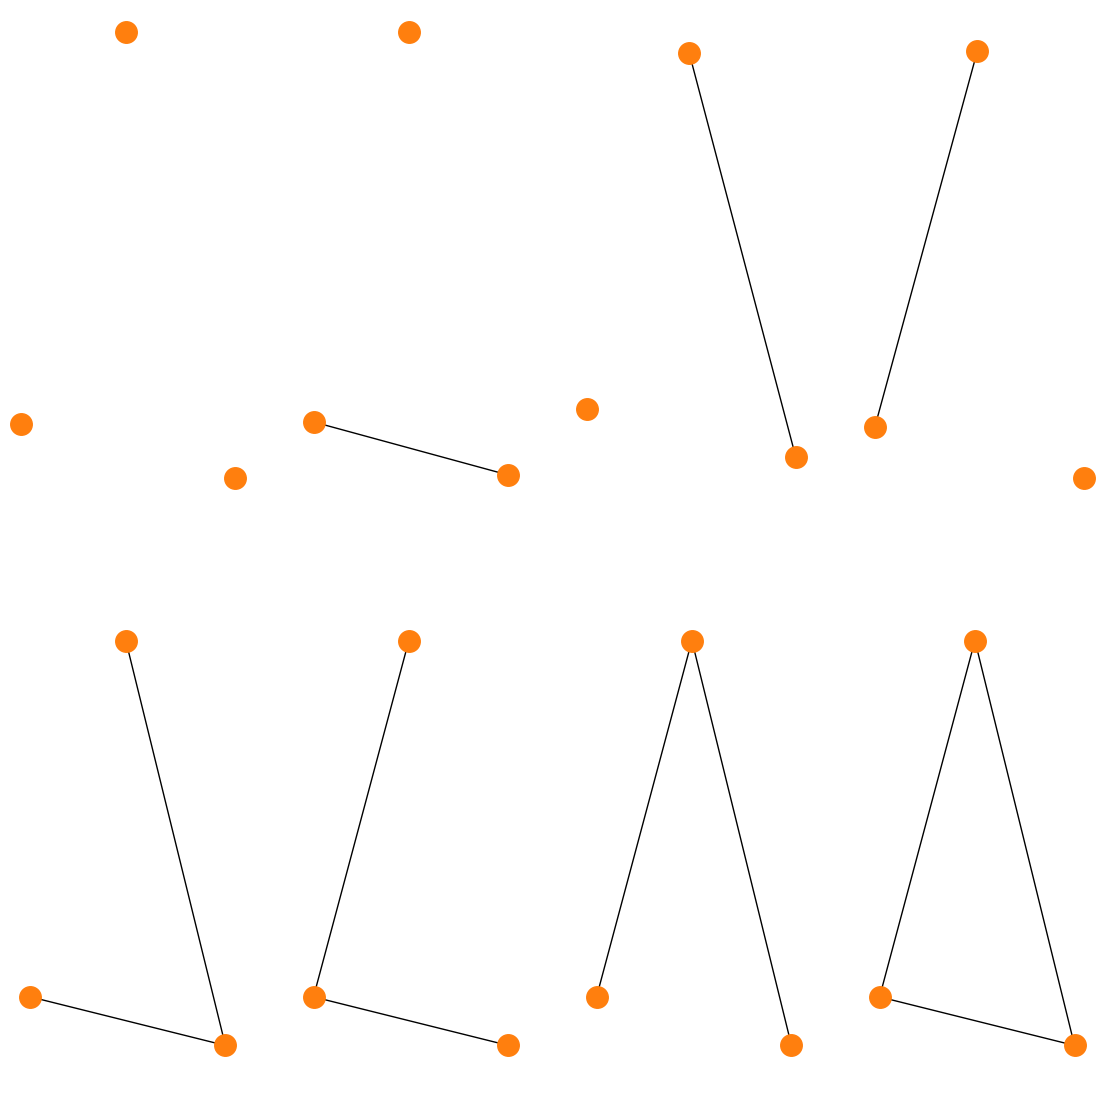

In [6]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def draw_all_simple_graphs(N):

    M = int(scipy.special.comb(N,2))
    
    edges = list(itertools.combinations(range(N), 2))

    graphs = list(powerset(edges))

    cont = 0

    fig, all_axes = plt.subplots(2**(N-2), int((2**M)/2**(N-2)), figsize=(14, 14))
    ax = all_axes.flat

    g_0 = nx.Graph()

    for i in range(N):
        g_0.add_node(i)

    for edge in graphs[0]:
        g_0.add_edge(*edge)

    pos = nx.spring_layout(g_0, iterations=100, seed=300)
    
    for graph in graphs:

        g = nx.Graph()

        for i in range(N):
            g.add_node(i)

        for edge in graph:
            g.add_edge(*edge)

        nx.draw(g, ax=ax[cont], pos=pos, node_size=240, width=1, node_color="tab:orange",)

        cont += 1
        
    plt.show()
      
draw_all_simple_graphs(3)

#### 2.2. Algoritmo con optimización

Esta implementación tiene el defecto de ser lenta, ya que por cada iteración del sumatorio estamos recalculando términos. Para solventar esto, vamos a reimplementar un algoritmo con **memoria**.

In [5]:
class get_pconexo_optimized:
    def __init__(self, N):
        self.N = N
        # Lista para almacenar los valores de PConexo y evitar recálculos
        self.cache = [-1.0]*N # -1 indica que el valor no ha sido calculado
        
    def get_pconexo_recursive(self, N, p) -> float:
        
        # Casos base
        if N == 1:
            return 1
        elif N == 2:
            return p

        # Si el valor ya ha sido calculado, retornar el valor almacenado
        if self.cache[N-1] != -1:
            return self.cache[N-1]
        else:
            sum = 0

            for i in range(1, N):
                sum+=self.get_pconexo_recursive(i,p)*scipy.special.comb(N-1, i-1)*np.power((1-p),(i*(N-i)))

            self.cache[N-1] = 1-sum
            return 1-sum

    def get_pconexo(self, p) -> float:
        self.clear_cache()
        return self.get_pconexo_recursive(self.N, p)

    def clear_cache(self):
        self.cache = [-1.0]*len(self.cache)

optimized = get_pconexo_optimized(6)
print(f'Probabilidad de que un grafo aleatorio de 3 vértices con p=0.5 sea conexo: {optimized.get_pconexo(0.5)}')

Probabilidad de que un grafo aleatorio de 3 vértices con p=0.5 sea conexo: 0.81494140625


#### 2.3. Test de rendimiento de ambos algoritmos

In [27]:
time_start = time.time()
pconexo = get_pconexo(20, 0.5)
total_time = time.time() - time_start

optimized = get_pconexo_optimized(20)

time_start = time.time()
pconexo_optimized = optimized.get_pconexo(0.5)
total_time_optimized = time.time() - time_start

print('Test de rendimiento')
print(f'Cálculo de PConexo para N=20 y p=0.5')
print(f'Tiempo total sin optimizar: {total_time} segundos')
print(f'Tiempo total optimizado: {total_time_optimized} segundos')
print(f'Optimización: {total_time/total_time_optimized}x')
print(f'Son iguales: {pconexo==pconexo_optimized}')


Test de rendimiento
Cálculo de PConexo para N=20 y p=0.5
Tiempo total sin optimizar: 3.7685599327087402 segundos
Tiempo total optimizado: 0.002435922622680664 segundos
Optimización: 1547.0770284819419x
Son iguales: True


#### 2.4. Algoritmo de fuerza bruta

Para comprobar que el algoritmo del foro es correcto podemos generar muchos grafos aleatorios y comprobar su conexidad, de esta forma podemos estimar `pconexo`

##### 2.4.1. Implementación

In [13]:
def random_graph(n, p):
    """
    Devuelve un grafo aleatorio con n vértices y probabilidad p de que haya una arista entre dos vértices
    """
    G = {}
    for i in range(n):
        G[i] = []
        for j in range(n):
            if i != j:
                if random() < p:
                    G[i].append(j)
    return G

def es_conexo(G):
    """
    Devuelve True si el grafo G es conexo, False en caso contrario
    """
    visitados = [False] * len(G)
    visitados[0] = True
    pila = [0]
    while pila:
        v = pila.pop()
        for w in G[v]:
            if not visitados[w]:
                visitados[w] = True
                pila.append(w)
    return all(visitados)

def get_pconexo_bruteforce(n, p):
    """
    Devuelve la probabilidad de que un grafo aleatorio con n vértices y probabilidad p de que haya una arista entre dos vértices sea conexo
    """

    ITERACIONES = 100000

    c = 0
    for _ in range(ITERACIONES):
        G = random_graph(n, p)
        if es_conexo(G):
            c += 1
    return c / ITERACIONES

print(f'Probabilidad de que un grafo aleatorio de 3 vértices con p=0.5 sea conexo: {get_pconexo_bruteforce(3, 0.5)}')

Probabilidad de que un grafo aleatorio de 3 vértices con p=0.5 sea conexo: 0.49928


##### 2.4.2. Comparación de algoritmos

Vamos a comprobar cuanto difieren los dos algoritmos, para ello vamos a graficar `pconexo` en función de $N$ para ambas implementaciones.
La siguiente celda tarda mucho en ejecutarse debido a que la fuerza bruta es computacionalmente muy costosa.

Se puede comprobar cambiando la p de la función que las dos funciones dan resultados similares.

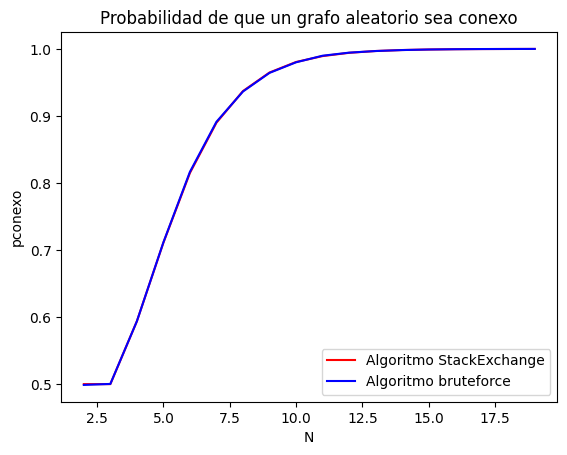

Los algoritmos tienen una diferencia media de 0.0004184758002532818


In [25]:
def plot_comparation(p):
    n_range = range(2, 20)
    
    f = [get_pconexo_optimized(n).get_pconexo(p) for n in n_range]
    f_bruteforce=[get_pconexo_bruteforce(n, p) for n in n_range]
    
    plt.plot(n_range, f, 'r', label='Algoritmo StackExchange')
    plt.plot(n_range, f_bruteforce, 'b', label='Algoritmo bruteforce')
    plt.xlabel('N')
    plt.ylabel('pconexo')
    plt.title(f'Probabilidad de que un grafo aleatorio sea conexo')
    plt.legend()
    plt.show()

    # Mostrar la diferencia de forma numérica
    sub = np.subtract(f, f_bruteforce)
    sum = 0
    for num in sub:
        sum+=abs(num)
    
    error = sum/len(sub)
    print(f'Los algoritmos tienen una diferencia media de {error}')

plot_comparation(0.5)

<a name="3"></a>
### 3. Algoritmos para obtener la probabilidad de conexión en función de la probabilidad de que el grafo sea conexo

#### 3.1. Algoritmo sin optimización

Como se trata de una función con recursividad va a ser dificil despejar $p$ por lo que vamos a estimar su valor con ingeniería inversa. Este primer algoritmo va sumando $0.01$ hasta que `pconexo` esté cerca de $0.5$. No es muy exacto y es un algoritmo lento ya que siempre usa el mismo incremento.

In [11]:
def get_p(N, pconexo) -> float:
    p = 0

    optimized = get_pconexo_optimized(N)

    
    while optimized.get_pconexo(p) < pconexo:
        p += 0.01
        
    return p

pconexo = 0.5
n = 3
p = get_p(n, pconexo)
print(f'p para que el grafo G=({n},p) tenga un {pconexo*100}% de ser conexo: {"%.4f" % p}')
print(f'Probabilidad de que un grafo G=({n},{"%.1f" % p}) sea conexo: {"%.4f" % get_pconexo(n, p)}')

p para que el grafo G=(3,p) tenga un 50.0% de ser conexo: 0.5000
Probabilidad de que un grafo G=(3,0.5) sea conexo: 0.5000


#### 3.2. Algoritmo con optimización

Para encontrar el valor de forma más rápida podemos reutilizar un algoritmo de **búsqueda de raices**. Lo único que tenemos que hacer es reescribir nuestra función para que tenga una raíz en pconexo.

In [17]:
def get_p_optimized(N, pconexo) -> float:
    optimized = get_pconexo_optimized(N)
    
    # Creamos una función que tenga una raiz en pconexo
    f = lambda p: optimized.get_pconexo(p) - pconexo
    
    # Utilizamos el método de Brent para encontrar la raíz (la probabilidad p que buscamos)
    p = scipy.optimize.brentq(f, 0, 1)

    return p

pconexo = 0.5
n = 3
p = get_p_optimized(n, pconexo)
print(f'p para que el grafo G=({n},p) tenga un {pconexo*100}% de ser conexo: {"%.4f" % p}')
print(f'Probabilidad de que un grafo G=({n},{"%.1f" % p}) sea conexo: {"%.4f" % get_pconexo(n, p)}')

p para que el grafo G=(3,p) tenga un 50.0% de ser conexo: 0.5000
Probabilidad de que un grafo G=(3,0.5) sea conexo: 0.5000


#### 3.3. Test de rendimiento de ambos algoritmos

Si comprobamos el rendimiento de los dos algoritmos vemos que a pesar de utilizar un algoritmo que en principio es mucho más rápido, el algoritmo sin optimizar es mejor.

ERROR! Session/line number was not unique in database. History logging moved to new session 3


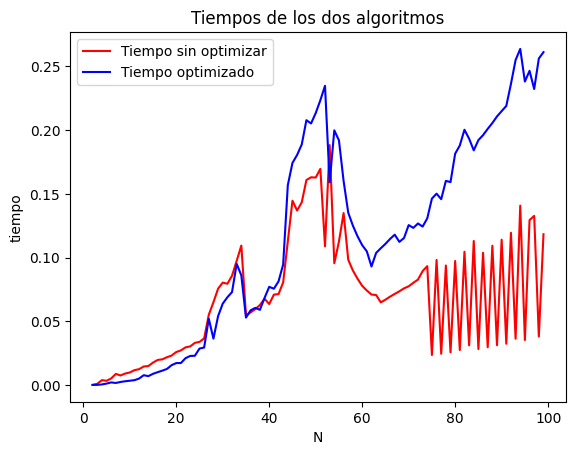

In [14]:
times = []
times_optimized = []

n_range = range(2, 100)

for i in n_range:

    time_start = time.time()
    get_p(i, pconexo)
    times.append(time.time() - time_start)

    time_start = time.time()
    get_p_optimized(i, pconexo)
    times_optimized.append(time.time() - time_start)

plt.plot(n_range, times, 'r', label='Tiempo sin optimizar')
plt.plot(n_range, times_optimized, 'b', label='Tiempo optimizado')
plt.xlabel('N')
plt.ylabel('tiempo')
plt.title(f'Tiempos de los dos algoritmos')
plt.legend()
plt.show()

#### 3.4. Comprobación de errores de ambos algoritmos

Lo primero que salta a la vista son los picos de error de la función sin optimizar, no estoy completamente seguro de porque se desvía tantisimo del valor de $p$ en estos puntos (como en $N=98$), pero tiene que ver seguro con la poca precisión del algoritmo (solo sumamos $0.01$ para encontrar $p$).

De todos modos si calculamos el error medio sin considerar los picos, vemos que la función con optimización tiene un error muchísimo más bajo.

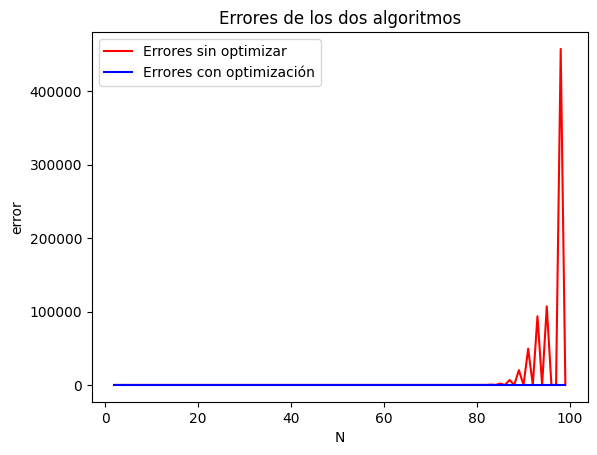

Error medio sin optimizar (hasta N=80): 0.4733877401655314
Error medio con optimización (hasta N=80): 4.677819313338038e-13


In [15]:
n_range = range(2,100)

errors = []
errors_optimized = []

sum = 0
sum_optimized = 0

cont = 0

for n in n_range:
    p = get_p(n, pconexo)
    p_optimized = get_p_optimized(n, pconexo)
    
    optimized = get_pconexo_optimized(n)

    error = abs(optimized.get_pconexo(p) - pconexo)
    error_optimized = abs(optimized.get_pconexo(p_optimized) - pconexo)

    # Sumamos para calcular el error medio de cada una de las funciones (hasta n=80 para evitar los picos)
    if n<=80:
        sum += error
        sum_optimized += error_optimized
        cont += 1

    # Rellenamos la lista de errores para crear la gráfica
    errors.append(error)
    errors_optimized.append(error_optimized)

plt.plot(n_range, errors, 'r', label='Errores sin optimizar')
plt.plot(n_range, errors_optimized, 'b', label='Errores con optimización')
plt.xlabel('N')
plt.ylabel('error')
plt.title(f'Errores de los dos algoritmos')
plt.legend()
plt.show()

print(f'Error medio sin optimizar (hasta N=80): {sum/cont}')
print(f'Error medio con optimización (hasta N=80): {sum_optimized/cont}')

#### 3.5. Gráfico de las funciones

Si dibujamos ambas funciones vemos que el algoritmo con búsqueda de raices es más preciso.
También se puede observar que en valores altos también deja de funcionar correctamente como hemos visto antes en los errores.

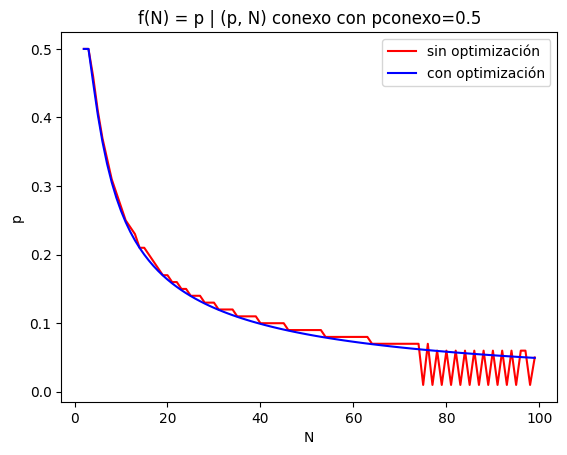

In [18]:
f = [get_p(i, pconexo) for i in n_range]   
f_optimized = [get_p_optimized(i, pconexo) for i in n_range]
plt.plot(n_range, f, 'r', label='sin optimización')
plt.plot(n_range, f_optimized, 'b', label='con optimización')
plt.xlabel('N')
plt.ylabel('p')
plt.title(f'f(N) = p | (p, N) conexo con pconexo={pconexo}')
plt.legend()
plt.show()

<a name="4"></a>
### 4. Análisis del resultado

Vemos que cuanto mayor es $N$ más tenemos que reducir $p$ para que `pconexo=0.5`, esto se debe a que cuanto mayor es el número de nodos de un grafo aleatorio, más fácil es que el grafo sea conexo. Incluso para probabilidades bajas de conexión entre nodos, si el $N$ es suficientemente alto la probabilidad de que el grafo aleatorio sea conexo acaba convergiendo a $1$ [[2]](https://math.stackexchange.com/questions/2862907/prove-that-probability-of-connectivity-of-a-random-graph-is-increasing-with-the?noredirect=1&lq=1)

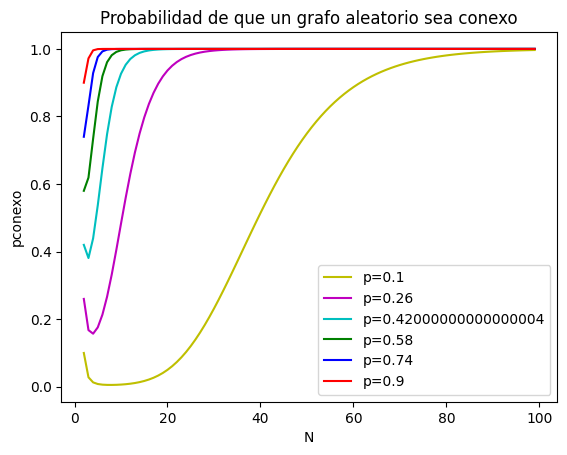

In [12]:
colors = ['r','b','g','c','m','y']

n_range = range(2,100)
p_range = np.linspace(0.1, 0.9, num=len(colors))

optimized = get_pconexo_optimized(n)

for p in p_range:
    f = [get_pconexo_optimized(n).get_pconexo(p) for n in n_range]
    plt.plot(n_range, f, f'{colors.pop()}', label=f"p={p}")
    
plt.xlabel('N')
plt.ylabel('pconexo')
plt.title(f'Probabilidad de que un grafo aleatorio sea conexo')
plt.legend()
plt.show()